In [148]:
import torch
import sys
import os
import os.path as osp
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, \
balanced_accuracy_score, accuracy_score
from sklearn import metrics
import math

In [2]:
os.environ['USER_PATH']='/home/users/richras/Ge2Net_Repo'
os.environ['USER_SCRATCH_PATH']="/scratch/users/richras"
os.environ['IN_PATH']='/scratch/groups/cdbustam/richras/data_in'
os.environ['OUT_PATH']='/scratch/groups/cdbustam/richras/data_out'
os.environ['LOG_PATH']='/scratch/groups/cdbustam/richras/logs/'

In [3]:
os.chdir(os.environ.get('USER_PATH'))

In [142]:
%load_ext autoreload
%autoreload 2
from src.utils.dataUtil import load_path, save_file, vcf2npy, get_recomb_rate, interpolate_genetic_pos, form_windows
from src.utils.modelUtil import Params, load_model, convert_coordinates
from src.utils.labelUtil import getSuperpopBins, repeat_pop_arr
from src.utils.decorators import timer
from src.models import AuxiliaryTask, LSTM, Attention, BasicBlock, Model_A, Model_B, Model_C, BOCD
from src.models.distributions import Multivariate_Gaussian
from src.main.evaluation import eval_cp_batch, reportChangePointMetrics, t_prMetrics, cpMethod, eval_cp_matrix, \
getCpPred
from src.main.settings_model import parse_args, MODEL_CLASS
import test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load the model and use valid data 

In [173]:
# Specify the dataset to be evaluated
# chm22 pca full dataset and model
labels_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_2_geo')
data_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_2_geo')
models_path=osp.join(os.environ['OUT_PATH'],'humans/training/Model_B_exp_id_3_data_id_2_geo/') 
dataset_type='valid'

In [174]:
config={}
config['data.labels']=labels_path 
config['data.dir']=data_path 
config['models.dir']=models_path
config['data.dataset_type']=dataset_type
config['cuda']='cuda'
config['model.loadBest']=False
json_path = osp.join(config['models.dir'], 'params.json')
assert osp.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = Params(json_path)
params.rtnOuts=True
params.mc_dropout=True
params.mc_samples=100
params.cp_tol=0
results, valid_dataset=test.main(config, params)

 device used: cuda
Loading the datasets...
Finished 'transform_data' in 26.6895 secs
Finished '__init__' in 195.2192 secs
model ['Model_B.model_B'] : AuxiliaryTask.AuxNetwork
model ['Model_B.model_B'] : LSTM.BiRNN
model ['Model_B.model_B'] : BasicBlock.logits_Block
best val loss metrics : {'gcd': 1110.283438053671, 'mse': 0.06311022749293732, 'smooth_l1': 0.031429237473531824, 'weighted_loss': 0.25271466988381014, 'loss_main': 0.25271466988381014, 'loss_aux': 0.5458145082388942}
at epoch : 115
train loss metrics: {'gcd': 625.7635940356992, 'mse': 0.03081435189350855, 'smooth_l1': 0.015342990467481277, 'weighted_loss': 0.13171339529412318, 'loss_main': 0.12026696741213297, 'loss_aux': 0.48634255288392114}
best val cp metrics : {'loss_cp': 0.0818903584614429, 'Precision': 1.0, 'Recall': 0.4043835616438356, 'Accuracy': 0.9863497688086083, 'A_major': 1.0, 'BalancedAccuracy': 0.7021917808219178}
train cp metrics: {'loss_cp': 0.20640823618938847, 'Precision': 0.9940147329650092, 'Recall': 0.

In [175]:
results.t_accr, results.t_cp_accr

({'gcd': 1181.0243152845599,
  'loss_aux': 0.5422720884334082,
  'loss_main': 0.24008517248876454,
  'mse': 0.055690286965302385,
  'smooth_l1': 0.027774037697059602,
  'weighted_loss': 0.24008517248876454},
 {'A_major': 0.99998782037108,
  'Accuracy': 0.9931117929216542,
  'BalancedAccuracy': 0.7022052604790822,
  'Precision': 0.9961643835616438,
  'Recall': 0.4044227005870841,
  'loss_cp': 0.20357275776759864})

In [176]:
results.t_out.coord_main=results.t_out.coord_main.mean(0)

In [177]:
y_pred = results.t_out.coord_main
n_vec_dim=y_pred.shape[-1]
data_tensor = torch.tensor(y_pred).float()
batch_size_cpd = data_tensor.shape[0]
mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
mean_var=torch.mean(torch.var(data_tensor, dim =1),dim=0).unsqueeze(0)
cov_prior = (mean_var.repeat(batch_size_cpd,1).unsqueeze(1)* torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
cov_x = cov_prior
likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
T = params.n_win
model_cpd = BOCD.BOCD(None, T, likelihood_model, batch_size_cpd)
posterior, _, predictive, e_mean = model_cpd.run_recursive(data_tensor, 'cpu')

Finished 'run_recursive' in 186.7439 secs


In [178]:
granular_pop_dict = load_path(osp.join(labels_path, 'granular_pop.pkl'), en_pickle=True)
superop_dict=load_path(osp.join(labels_path, 'superpop.pkl'), en_pickle=True)
pop_sample_map=pd.read_csv(osp.join(labels_path, 'pop_sample_map.tsv'),sep="\t")
pop_arr=repeat_pop_arr(pop_sample_map)
cp_target=valid_dataset.data['cps']
seqlen=cp_target.shape[1]
rev_pop_dict={v:k for k,v in granular_pop_dict.items()}

In [1862]:
# index = 2500
# index=2620
# index=2650
# index=3000
# index=3100
# index=2300
# index=2320
# index=2338 #interesting Mansi pop
# index=2339 # nice example showing Karitiana
# index=2344 #interesting clusters of Mongolia
# index=2346 # interesting African diversity
# index=2355#int. Iranian sample
# index=2366# Piapioco and Pima both
# index=2388#int example
# index=2398#Biaka/Luhya
# index=2403#Quechua
# index=2414#incorrect Khomani San
# index=2421#uyugur
index=2451
true_cpsSample=cp_target[index,:].detach().cpu().numpy()
y_predSample=results.t_out.coord_main[index,:]
y_trueSample=valid_dataset.data['y'][index,:].detach().cpu().numpy()
granularpopSample=valid_dataset.data['granular_pop'][index,:].detach().cpu().numpy()
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]

In [1863]:
y_predSample.shape

(317, 3)

In [1864]:
pred_cps=getCpPred(cpMethod.gradient.name, y_predSample, 0.1, 1, len(true_cpsSample))
pred_cps=pred_cps.squeeze(0).detach().cpu().numpy()# squeeze the batch dimension of 1

In [1865]:
predBOCDSample=model_cpd.cp[index,:]
pred_cps_BOCD=getCpPred(cpMethod.BOCD.name, predBOCDSample, 5.0, 1, len(true_cpsSample))
pred_cps_BOCD=pred_cps_BOCD.squeeze(0).detach().cpu().numpy()# squeeze the batch dimension of 1

In [1866]:
cpIdx=np.nonzero(pred_cps_BOCD)[0]
remWin=3
for i in cpIdx:
    low=max(0,i-remWin)
    high=min(seqlen, i+remWin)
    pred_cps_BOCD[low:high]=1

In [1867]:
mappedSpArr=getSuperpopBins(pop_arr, labels_path, y_predSample.reshape(-1,3))
mappedSpArr=mappedSpArr.squeeze(1)

Finished 'getSuperpopBins' in 0.0847 secs


In [1868]:
y_predsTrue=valid_dataset.data['y'].detach().cpu().numpy().reshape(-1,3)
superpopsTrue=valid_dataset.data['superpop'].detach().cpu().numpy().reshape(-1,)

In [1869]:
@timer
def plot_sample(granularPopSample, y_predSample, y_trueSample, **kwargs):
    backgroundAxis=kwargs.get('backgroundAxis')
    y_predCps=kwargs.get('y_predCps')
    y_preds=kwargs.get('y_preds')
    superpops=kwargs.get('superpops')
    cpShow=kwargs.get('cpShow')
    pred_cps=kwargs.get('pred_cps')
    mappedSpArr=kwargs.get('mappedSpArr')
    fig, ax = plt.subplots(figsize=(12,14))
    
    gs1 = fig.add_gridspec(nrows=3, ncols=1, height_ratios=[13,1,1])
    ax1=fig.add_subplot(gs1[0],projection='3d')
    ax2=fig.add_subplot(gs1[1])
    ax3=fig.add_subplot(gs1[2])
    for axis in [ax, ax2, ax3]:
        axis.set_yticks([])
        axis.spines['top'].set_color('none')
        axis.spines['left'].set_color('none')
        axis.spines['right'].set_color('none')
    ax.set_xticks([])
    plt.subplots_adjust(hspace=0.01)
    
    if backgroundAxis is not None:
        lgnd, colorsPop_sp_dict =plot_all(ax1, y_preds, superpops, cpShow=False)
    else:
        continentaPops=list(superop_dict.values())
        colors_Sp = sns.color_palette("bright", 10)
        del colors_Sp[1]
        del colors_Sp[4]
        del colors_Sp[5]
        colorsPop_sp_dict = {k:v for k,v in zip(continentaPops, colors_Sp)}
        patches=[]
        for k, val in superop_dict.items():
            patches.append(mpatches.Patch(color = colorsPop_sp_dict[val], label = k))
        lgnd = ax1.legend(handles=patches, loc="upper right",fontsize=15)
    ax1.add_artist(lgnd)    
    colors_pop = sns.color_palette("rainbow", len(np.unique(granularPopSample)))
    colors_pop_dict = {k:v for k,v in zip(np.unique(granularPopSample), colors_pop)}

    alpha=[1]*len(y_predSample)
    if cpShow is None:
        alpha=(pred_cps==0).astype(float)
    
    ax1.scatter(y_predSample[:,0], y_predSample[:,1], y_predSample[:,2], \
               color = [colors_pop_dict[x]+(y,) for x,y in zip(granularPopSample, alpha)], s=50, zorder=0) 
    ax1.scatter(y_trueSample[:,0], y_trueSample[:,1], y_trueSample[:,2], \
               color = [colors_pop_dict[x] for x in granularPopSample], marker='X', s=200, zorder=0)
    
    for axis in [ax1.xaxis, ax1.yaxis, ax1.zaxis]:
        axis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        axis._axinfo["grid"]['color'] = (1,1,1,0)
    patches=[]
    for i, val in enumerate(np.unique(granularPopSample)):
        patches.append(mpatches.Patch(color = colors_pop_dict[val], label = val))
    ax1.legend(handles=patches, loc="upper left", fontsize=20)
    
    #chm plot ground truth
    ax2.scatter(np.arange(len(y_trueSample)),np.ones(len(y_trueSample)),\
                color=[colors_pop_dict[x] for x in granularPopSample], marker='s')
    ax2.set_title('Labeled Chromosome22', fontsize=30, y=0.3)
    #chm plot of predictions
    ax3.scatter(np.arange(len(mappedSpArr)),np.ones(len(mappedSpArr)),\
                color=[colorsPop_sp_dict[x]+(y,) for x,y in zip(mappedSpArr,alpha)], marker='s')
    ax3.set_title('Predicted Chromosome22', fontsize=30, y=0.3)
    
    for ax in [ax2, ax3]:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(4))
        ax.xaxis.set_ticks_position('bottom')
        ax.tick_params(which='major', width=2, length=10, labelsize=25)
        ax.tick_params(which='minor', width=2, length=10, labelsize=10)
        ax.set_xlim(0, 316)
        ax.set_ylim(0.99,1.09)
        positions = [0, 160, 300]
        x_labels = [0, 150000, 317000]
        ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
        ax.xaxis.set_major_formatter(ticker.FixedFormatter(x_labels))
    
    fig.tight_layout()
    plt.show()

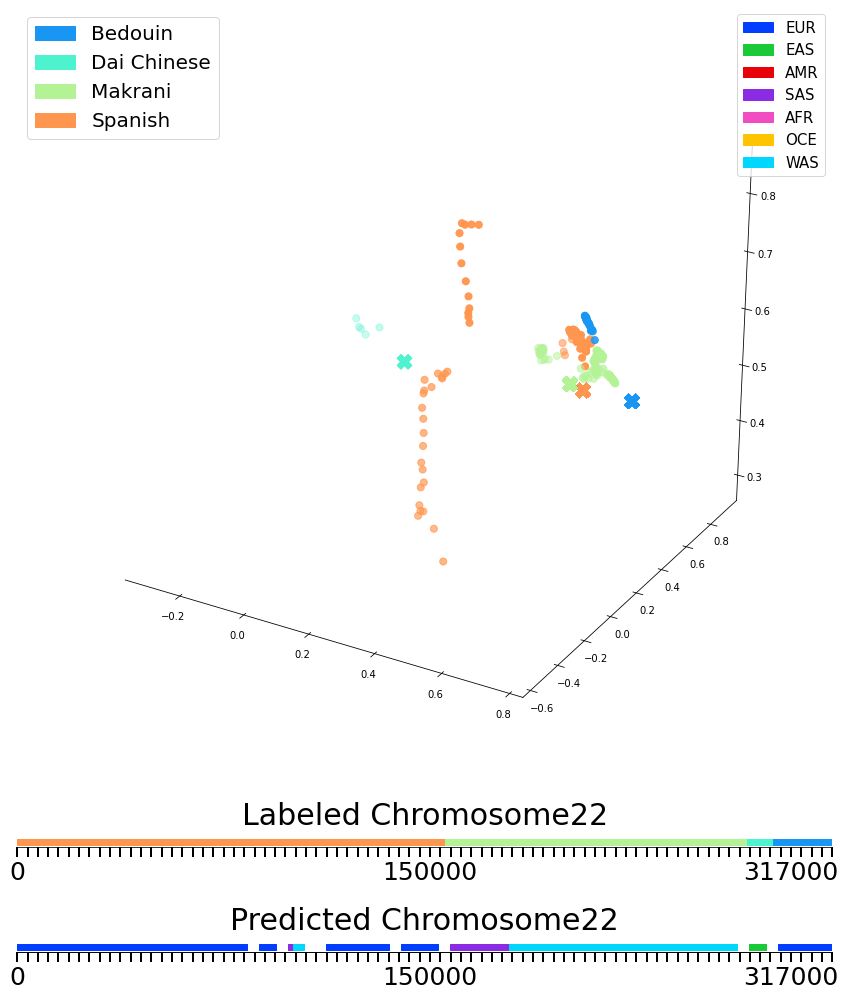

Finished 'plot_sample' in 0.8786 secs


In [1870]:
plot_sample(namesSample, y_predSample, y_trueSample, pred_cps=pred_cps_BOCD, mappedSpArr=mappedSpArr)

In [1871]:
def plot_coordinates_map(granularPopNames, pred_coord, lbl_coord, **kwargs):
    """
    plotly plot for coordinates on a map
    label: target label vector (int) for the specific sample
    data_coordinates: lat, long for the specific sample
    rev_pop_order: dict with keys as target label ints and values
    as granular population name
    """
    cpShow=kwargs.get('cpShow')
    pred_cps=kwargs.get('pred_cps') 
    alpha=[1.0]*len(lbl_coord)
    if cpShow is None:
        alpha=(pred_cps==0).astype(float)
    fig = go.Figure(go.Scattergeo())
    colors_pop = sns.color_palette("magma", len(np.unique(granularPopNames)))
    colors_pop_dict = {k:v for k,v in zip(np.unique(granularPopNames), colors_pop)}
    fig.add_trace(go.Scattergeo(lon=pred_coord[:,1], lat=pred_coord[:,0],text = granularPopNames,\
    marker_color=['rgba'+str(colors_pop_dict[x]+(y,)) for x,y in zip(granularPopNames, alpha)]))
    fig.update_traces(marker_size = 5)
    fig.add_trace(go.Scattergeo(lon=lbl_coord[:,1], lat=lbl_coord[:,0], marker = dict(symbol = 'square'), \
                                text = granularPopNames))
    fig.update_traces(marker_size = 5)

    fig.show()

In [1872]:
y_trueSample.shape

(317, 3)

In [1873]:
lbl_coord=convert_coordinates(y_trueSample[:,0], y_trueSample[:,1], y_trueSample[:,2])
pred_coord=convert_coordinates(y_predSample[:,0], y_predSample[:,1], y_predSample[:,2])
granularPopNames=namesSample
plot_coordinates_map(granularPopNames, pred_coord, lbl_coord, pred_cps=pred_cps_BOCD)

In [1703]:
@timer
def plot_all(ax, y_preds, superpops, **kwargs):
    cpShow=kwargs.get('cpShow')
    pred_cps=kwargs.get('pred_cps')    
    continentaPops=list(superop_dict.values())
    colors_pop = sns.color_palette("bright", 10)
    del colors_pop[1]
    del colors_pop[4]
    del colors_pop[5]
    colors_pop_dict = {k:v for k,v in zip(continentaPops, colors_pop)}
    
    alpha=[0.03]*len(y_preds)
    if cpShow is None:
        alpha=(pred_cps==0).astype(float)
    
    ax.scatter(y_preds[:,0], y_preds[:,1], y_preds[:,2], \
               color = [colors_pop_dict[x]+(y,) for x,y in zip(superpops, alpha)], marker=".", s=0.05,zorder=-1) 
    
    patches=[]
    for k, val in superop_dict.items():
        patches.append(mpatches.Patch(color = colors_pop_dict[val], label = k))
    lgnd = ax.legend(handles=patches, loc="upper right", fontsize=15)
    return lgnd, colors_pop_dict


In [588]:
y_preds=results.t_out.coord_main
y_predCps=getCpPred(cpMethod.gradient.name, y_predSample, 0.1, y_preds.shape[0], y_preds.shape[1])
y_predCps=y_predCps.detach().cpu().numpy().reshape(-1,)
y_preds=y_preds.reshape(-1,3)
superpops=valid_dataset.data['superpop'].detach().cpu().numpy().reshape(-1,)

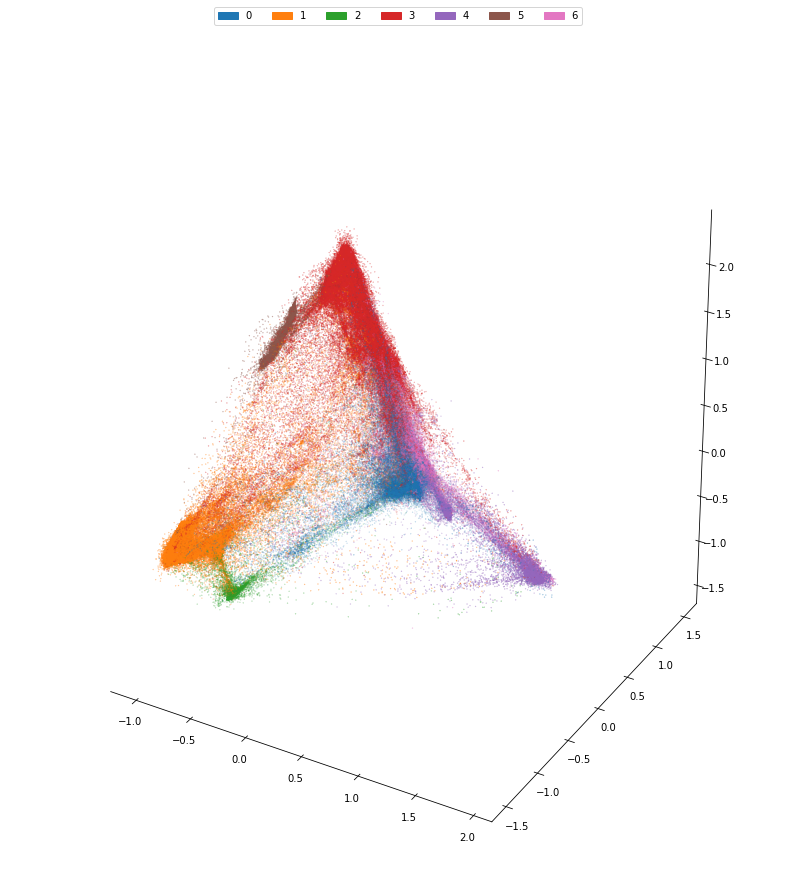

Finished 'plot_all' in 27.6816 secs


In [130]:
lgnd, _=plot_all(y_preds, superpops, pred_cps=y_predCps)

In [65]:
superop_dict

{'AFR': 4, 'AMR': 2, 'EAS': 1, 'EUR': 0, 'OCE': 5, 'SAS': 3, 'WAS': 6}